In [1]:
import os
import cv2
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img


np.random.seed(1000)
# ignore information messgaes from tensorflow, but we will receieve error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = 'D:/CUSTOM_DATASET/2D_Dataset_00' 
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test')

In [3]:
IMG_SIZE = 128
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
    
print(CATEGORIES)

['Negative', 'Positive']


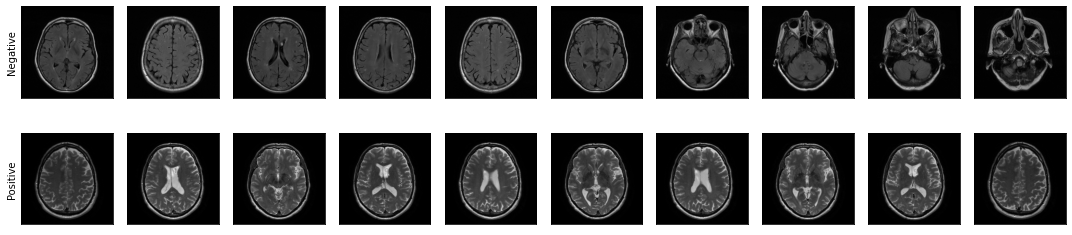

In [4]:
plt.figure(figsize=(15,4))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(2,10,i+1)
        plt.imshow(img_array)
        if i%10 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%10 == 0:
            break

plt.tight_layout()        
plt.show() 

In [5]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c) # 'E:/DATASETS/classification/Face Mask Dataset/train/WithMask'
    class_num = CATEGORIES.index(c) # 0
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   # read the image
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
            training_data.append([img_resized, class_num]) # [ [img, 0], [], [], [], ...., []]
        except WException as e:
            pass
        
print(len(training_data))

100%|█████████████████████████████████████████████████████████████████████████████| 2720/2720 [00:05<00:00, 534.60it/s]

5440


In [6]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            test_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(test_data))

100%|███████████████████████████████████████████████████████████████████████████████| 680/680 [00:02<00:00, 226.82it/s]

1360


In [7]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (5440, 128, 128, 3) Y_train= (5440,)


In [8]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_test= (1360, 128, 128, 3) Y_test= (1360,)


In [9]:
X_train, X_test = X_train / 255.0, X_test / 255.0

In [10]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=(128,128,3)),
    
    ## hidden layers
    layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'), # input->(32,32) output->(28,28)
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    
    ## output layer
    layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [11]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [12]:
h = model.fit(x=X_train, y=Y_train, epochs=15, validation_data=(X_test, Y_test), batch_size=64)


Epoch 1/15
85/85 [==============================] - 65s 759ms/step - loss: 0.8805 - accuracy: 0.5185 - val_loss: 0.6127 - val_accuracy: 0.6684
Epoch 2/15
53/85 [=================>............] - ETA: 25s - loss: 0.5997 - accuracy: 0.6726

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

In [ ]:
score = model.evaluate(X_test,Y_test,verbose=0)

print("Accuracy: ",np.round(score[1]*100,3),"%")

In [ ]:
from skimage import io

#img_path = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS-qVyKwF4uUrg0Y1Iti50EfsC34-e3O0Gu3Q&usqp=CAU'
img_path = 'C:/Users/Mehedi Tamim/Downloads/download.jpg'


img = io.imread(img_path)
x =cv2.resize(img,(64, 64))
imgplot = plt.imshow(x)
x = np.expand_dims(x, axis=0)
preds = model.predict(x)
preds[0,0]
# dogs -> 1  
# cats -> 0 